# Danish fire insurance dataset

In [1]:
%run preamble.py
danish = pd.read_csv("../Data/danishv2.csv").x
K = 1000000

# Descriptive statistics , histogram and boxplot

In [2]:
print(danish.describe().to_latex())

\begin{tabular}{lr}
\toprule
{} &            x \\
\midrule
count &  2492.000000 \\
mean  &     3.062699 \\
std   &     7.976703 \\
min   &     0.313404 \\
25\%   &     1.157184 \\
50\%   &     1.633858 \\
75\%   &     2.645484 \\
max   &   263.250366 \\
\bottomrule
\end{tabular}



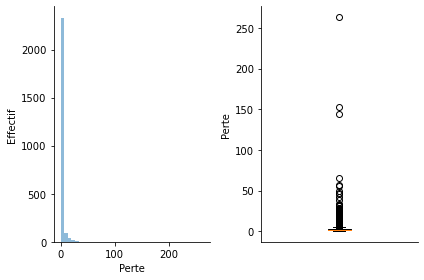

In [3]:
fig, axs = plt.subplots(1, 2, tight_layout=True)
num_bins = 40
# the histogram of the data
n, bins, patches = axs[0].hist(danish, num_bins, alpha=0.5)
axs[1].boxplot(danish)
axs[0].set_xlabel("Perte")
axs[0].set_ylabel("Effectif")
axs[1].set_ylabel("Perte")
axs[1].set_xticks([])
# plt.show()
sns.despine()
plt.savefig("../Figures/hist_boxplot_danish.pdf")

# Maximum likelihood estimation of common loss distributions

## Fitting the gamma distribution

      shape    scale           AIC           BIC
0  1.257994  2.43459  10490.053765  10501.695447


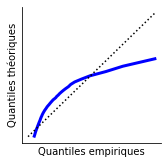

In [4]:
r, m, BIC, AIC = infer_gamma(danish, (1,1))
fit_gamma = pd.DataFrame({'shape': np.array([r]), "scale": np.array([m]), "AIC":np.array([AIC]), "BIC":np.array([BIC]) })
print(fit_gamma)
X0 = np.random.gamma(shape = r, scale  = m, size=K)
qq_plot(danish, X0, "blue")
sns.despine()
plt.savefig("../Figures/QQplot_gamma.pdf")

## Fitting the lognormal distribution

      shape     scale          AIC          BIC
0  0.671854  0.732317  8871.781777  8883.423459


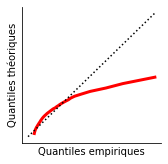

In [5]:
μ, σ, BIC, AIC = infer_lnorm(danish)
fit_lnorm = pd.DataFrame({'shape': np.array([σ]), "scale": np.array([μ]),"AIC":np.array([AIC]),"BIC":np.array([BIC])  })
print(fit_lnorm)
X0 = np.random.lognormal(mean = μ, sigma  = σ, size=K)
qq_plot(danish, X0, "red")
sns.despine()
plt.savefig("../Figures/QQplot_lnorm.pdf")

## Fitting the Weibull distribution

      shape     scale           AIC           BIC
0  0.947587  2.952484  10544.941033  10556.582715


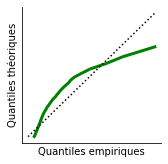

In [6]:
k, β, BIC, AIC = infer_weib(danish, (1,1))
fit_weibull = pd.DataFrame({'shape': np.array([k]), "scale": np.array([β]), "AIC":np.array([AIC]), "BIC":np.array([BIC]) })
print(fit_weibull)
X0 = np.random.weibull(k, size=K)* β
qq_plot(danish, X0, "green")
sns.despine()
plt.savefig("../Figures/QQplot_weib.pdf")

## Fitting the Pareto distribution

      shape     scale           AIC          BIC
0  0.313404  0.545817  11354.188278  11365.82996


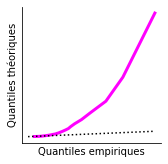

In [7]:
θ, α, BIC, AIC = infer_par(danish)
fit_pareto = pd.DataFrame({'shape': np.array([θ]), "scale": np.array([α]), "AIC":np.array([AIC]), "BIC":np.array([BIC]) })
print(fit_pareto)
X0 = θ * np.exp(np.random.exponential(size=K )/ α)
qq_plot(danish, X0, "magenta")
sns.despine()
plt.savefig("../Figures/QQplot_pareto.pdf")

# Maximum likelihood estimation of composite models

## Fitting the gamma-Pareto model

       shape      tail     thres          AIC          BIC
0  35.692752  1.312986  1.155785  7723.681774  7741.144297


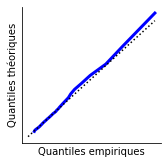

In [8]:
parms, BIC, AIC = mle_composite(danish, (1,1,1), "gam-par")
fit_gam_par = pd.DataFrame(np.append(parms, [AIC, BIC])).T
fit_gam_par.columns = ["shape", "tail", "thres", "AIC","BIC"]
print(fit_gam_par)
X0 = sim_gam_par(K, parms[0], parms[1], parms[2])
qq_plot(danish, X0, "blue")
sns.despine()
plt.savefig("../Figures/QQplot_gam_par.pdf")

## Fitting the Weibull-Pareto model

       shape      tail     thres         AIC          BIC
0  14.033784  1.261477  1.002991  7686.75154  7704.214063


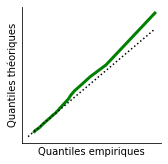

In [9]:
parms, BIC, AIC = mle_composite(danish, (1,1,1), "wei-par")
fit_wei_par = pd.DataFrame(np.append(parms, [AIC, BIC])).T
fit_wei_par.columns = ["shape", "tail", "thres", "AIC","BIC"]
print(fit_wei_par)
X0 = sim_wei_par(K, parms[0], parms[1], parms[2])
qq_plot(danish, X0, "green")
sns.despine()
plt.savefig("../Figures/QQplot_wei_par.pdf")

## Fitting the lognormal-Pareto

      shape      tail    thres          AIC          BIC
0  0.196517  1.328223  1.20743  7737.728264  7755.190787


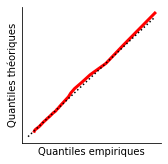

In [10]:
parms, BIC, AIC = mle_composite(danish, (0.5,1,1), "lnorm-par")
fit_lnorm_par = pd.DataFrame(np.append(parms, [AIC, BIC])).T
fit_lnorm_par.columns = ["shape", "tail", "thres", "AIC","BIC"]
print(fit_lnorm_par)
X0 = sim_lnorm_par(K, parms[0], parms[1], parms[2])
qq_plot(danish, X0, "red")
sns.despine()
plt.savefig("../Figures/QQplot_lnorm_par.pdf")

# Bayesian Inference of the composite model using Gibbs

## Fitting the gamma-Pareto model

In [13]:
loss_model, model_prior = "gam-par", "gamma"
a, b = np.array([0.1,0.1,0.1]), np.array([0.1, 0.1, 0.1])
popSize, step_size,  init_parms, parms_names = 2000, np.array([1.23557443e+01, 1.10333495e-03,4.41205123e-04]),\
[1.1 , 5 , 5], ["shape", "tail", "thres" ]
trace_gibbs_gam_par, acc = fit_model_gibbs(danish, loss_model, model_prior, a, b, popSize, step_size,
                    init_parms, parms_names)

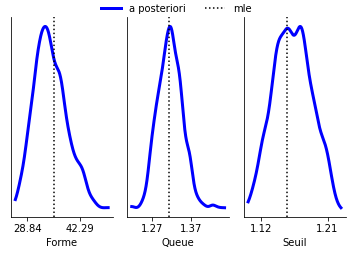

In [14]:
from scipy.stats import uniform
np.random.seed(123)
fig, axs = plt.subplots(1, 3, figsize=(5, 3.5))
x_labs = ["Forme", "Queue", "Seuil"]
for k in range(3):
    positions = np.linspace(min(trace_gibbs_gam_par[parms_names[k]]), max(trace_gibbs_gam_par[parms_names[k]]), 1000)
    kernel = st.gaussian_kde(trace_gibbs_gam_par[parms_names[k]])
    axs[k].plot(positions, kernel(positions), lw=3, label = "a posteriori", color = "blue")

    axs[k].axvline(fit_gam_par[parms_names[k]].values, color = "black", linestyle = "dotted", label = "mle")
    axs[k].set_yticks([])
    axs[k].set_xticks(np.round(
        trace_gibbs_gam_par[parms_names[k]].quantile([0.05, 0.95]).values, 2))
    axs[k].set_xlabel(x_labs[k])

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol = 3, borderaxespad=0., loc='upper center', 
           frameon=False)
sns.despine()
fig.tight_layout()
# print(fit_gam_par[parms_names[0]].values)
plt.savefig("../Figures/posterior_danish_gam_par.pdf")

## Fitting the Weibull Pareto model

In [15]:
loss_model, model_prior = "wei-par", "gamma"
a, b = np.array([0.1,0.1,0.1]), np.array([0.1, 0.1, 0.1])
popSize, step_size,  init_parms, parms_names = 2000, np.array([5, 0.01, 0.001]),\
[1.1 , 5 , 5], ["shape", "tail", "thres" ]
trace_gibbs_wei_par, acc = fit_model_gibbs(danish, loss_model, model_prior, a, b, popSize, step_size,
                    init_parms, parms_names)

[35.69275225]


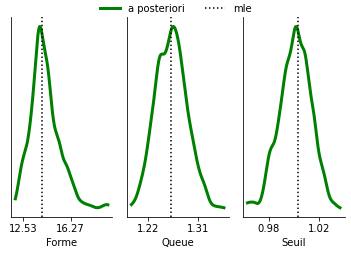

In [16]:
from scipy.stats import uniform
np.random.seed(123)
fig, axs = plt.subplots(1, 3, figsize=(5, 3.5))
x_labs = ["Forme", "Queue", "Seuil"]
for k in range(3):
    positions = np.linspace(min(trace_gibbs_wei_par[parms_names[k]]), max(trace_gibbs_wei_par[parms_names[k]]), 1000)
    kernel = st.gaussian_kde(trace_gibbs_wei_par[parms_names[k]])
    axs[k].plot(positions, kernel(positions), lw=3, label = "a posteriori", color = "green")

    axs[k].axvline(fit_wei_par[parms_names[k]].values, color = "black", linestyle = "dotted", label = "mle")
    axs[k].set_xticks(np.round(
        trace_gibbs_wei_par[parms_names[k]].quantile([0.05, 0.95]).values, 2))
    axs[k].set_yticks([]) 
    axs[k].set_xlabel(x_labs[k])

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol = 3, borderaxespad=0., loc='upper center', 
           frameon=False)
sns.despine()
fig.tight_layout()
print(fit_gam_par[parms_names[0]].values)
plt.savefig("../Figures/posterior_danish_wei_par.pdf")

In [17]:
trace_gibbs_wei_par[parms_names[k]].quantile([0.05, 0.95]).values

array([0.98006266, 1.0216901 ])

## Fitting the Lognormal Pareto distribution

In [18]:
loss_model, model_prior = "lnorm-par", "gamma"
a, b = np.array([0.1,0.1,0.1]), np.array([0.1, 0.1, 0.1])
popSize, step_size,  init_parms, parms_names = 2000, np.array([0.0001, 0.01, 0.001]),\
[1.1 , 5 , 5], ['shape', 'tail', 'thres' ]
trace_gibbs_lnorm_par, acc = fit_model_gibbs(danish, loss_model, model_prior, a, b, popSize, step_size,
                    init_parms, parms_names)

[35.69275225]


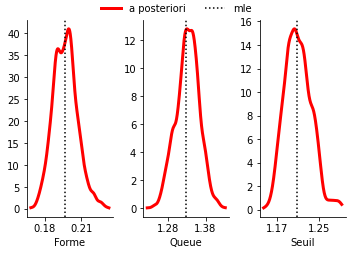

In [19]:
from scipy.stats import uniform
np.random.seed(123)
fig, axs = plt.subplots(1, 3, figsize=(5, 3.5))
x_labs = ["Forme", "Queue", "Seuil"]
for k in range(3):
    positions = np.linspace(min(trace_gibbs_lnorm_par[parms_names[k]]), max(trace_gibbs_lnorm_par[parms_names[k]]), 1000)
    kernel = st.gaussian_kde(trace_gibbs_lnorm_par[parms_names[k]])
    axs[k].plot(positions, kernel(positions), lw=3, label = "a posteriori", color = "red")

    axs[k].axvline(fit_lnorm_par[parms_names[k]].values, color = "black", linestyle = "dotted", label = "mle")
    axs[k].set_xticks(np.round(
        trace_gibbs_lnorm_par[parms_names[k]].quantile([0.05, 0.95]).values, 2))
    axs[k].set_xlabel(x_labs[k])

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol = 3, borderaxespad=0., loc='upper center', 
           frameon=False)
fig.tight_layout()
sns.despine()
print(fit_gam_par[parms_names[0]].values)
plt.savefig("../Figures/posterior_danish_lnorm_par.pdf")

# Bayesian inference and model comparison using SMC

In [11]:
start = time()
model_prior, a, b = "gamma", 0.1*np.array([1,1,1]), 0.1*np.array([1, 1, 1])
popSize, verbose, smc_method, paralell, nproc = 1000, True, "likelihood_anealing", True, 40
loss_models = ['lnorm-par', "wei-par", "gam-par"]
traces_like, res_df_like = fit_composite_models_smc(danish,loss_models, model_prior, a, b, popSize, verbose, smc_method, paralell, nproc)
print("Running time "+str(time()-start))

Fitting lnorm-par model
Fitting wei-par model
Fitting gam-par model
Running time 233.82525849342346


In [12]:
start = time()
model_prior, a, b = "gamma", np.array([0.1,0.1,0.1]), np.array([0.1, 0.1, 0.1])
popSize, verbose, smc_method, paralell, nproc = 1000, True, "data_by_batch", True, 40
loss_models = ['lnorm-par', "wei-par", "gam-par"]
traces_data, res_df_data = fit_composite_models_smc(danish,loss_models,
                                                     model_prior, a, b, popSize, verbose, smc_method, paralell, nproc)
print("Running time "+str(time()-start))

Fitting lnorm-par model
Fitting wei-par model
Fitting gam-par model
Running time 1088.6304249763489


## Fitting the gamma-Pareto model

[35.69275225]


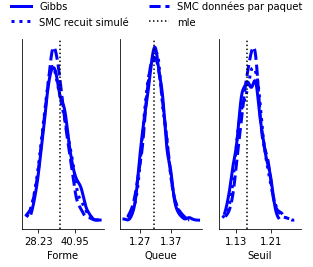

In [20]:
np.random.seed(123)
fig, axs = plt.subplots(1, 3, figsize=(5, 3.5))
loss_model = "gam-par"
x_labs = ["Forme", "Queue", "Seuil"]
for k in range(3):
    positions = np.linspace(min(trace_gibbs_gam_par[parms_names[k]]), max(trace_gibbs_gam_par[parms_names[k]]), 1000)
    kernel = st.gaussian_kde(trace_gibbs_gam_par[parms_names[k]])
    axs[k].plot(positions, kernel(positions), lw=3, label = "Gibbs", color = "blue")
    positions = np.linspace(min(traces_like[loss_model][parms_names[k]].values), 
                            max(traces_like[loss_model][parms_names[k]].values), 1000)
    kernel = st.gaussian_kde(traces_like[loss_model][parms_names[k]].values)
    axs[k].plot(positions, kernel(positions), lw=3, label = "SMC recuit simulé", 
                color = "blue", linestyle = "dotted")
    positions = np.linspace(min(traces_data[loss_model][parms_names[k]].values), 
                            max(traces_data[loss_model][parms_names[k]].values), 1000)
    kernel = st.gaussian_kde(traces_data[loss_model][parms_names[k]].values)
    axs[k].plot(positions, kernel(positions), lw=3, label = "SMC données par paquet", 
                color = "blue", linestyle = "dashed")

    axs[k].axvline(fit_gam_par[parms_names[k]].values, color = "black", linestyle = "dotted", label = "mle")
    axs[k].set_yticks([])
    axs[k].set_xlabel(x_labs[k])
    axs[k].set_xticks(np.round(
        traces_like[loss_model][parms_names[k]].quantile([0.05, 0.95]).values, 2))

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol = 2, borderaxespad=-0.2, loc='upper center', 
           frameon=False)
# fig.tight_layout()
sns.despine()
print(fit_gam_par[parms_names[0]].values)
plt.savefig("../Figures/smc_posterior_danish_gamma_par.pdf")

## Fitting the Weibull-Pareto model

[35.69275225]


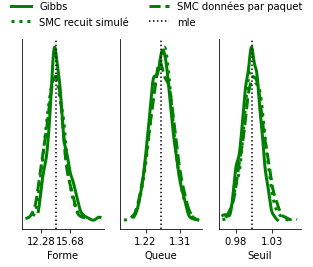

In [21]:
np.random.seed(123)
fig, axs = plt.subplots(1, 3, figsize=(5, 3.5))
loss_model = "wei-par"
for k in range(3):
    positions = np.linspace(min(trace_gibbs_wei_par[parms_names[k]]), max(trace_gibbs_wei_par[parms_names[k]]), 1000)
    kernel = st.gaussian_kde(trace_gibbs_wei_par[parms_names[k]])
    axs[k].plot(positions, kernel(positions), lw=3, label = "Gibbs", color = "green")
    positions = np.linspace(min(traces_like[loss_model][parms_names[k]].values), 
                            max(traces_like[loss_model][parms_names[k]].values), 1000)
    kernel = st.gaussian_kde(traces_like[loss_model][parms_names[k]].values)
    axs[k].plot(positions, kernel(positions), lw=3, label = "SMC recuit simulé", 
                color = "green", linestyle = "dotted")
    positions = np.linspace(min(traces_data[loss_model][parms_names[k]].values), 
                            max(traces_data[loss_model][parms_names[k]].values), 1000)
    kernel = st.gaussian_kde(traces_data[loss_model][parms_names[k]].values)
    axs[k].plot(positions, kernel(positions), lw=3, label = "SMC données par paquet", 
                color = "green", linestyle = "dashed")

    axs[k].axvline(fit_wei_par[parms_names[k]].values, color = "black", linestyle = "dotted", label = "mle")
    axs[k].set_yticks([])
    axs[k].set_xlabel(x_labs[k])
    axs[k].set_xticks(np.round(
        traces_like[loss_model][parms_names[k]].quantile([0.05, 0.95]).values, 2))

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol = 2, borderaxespad=-0.2, loc='upper center', 
           frameon=False)
sns.despine()
print(fit_gam_par[parms_names[0]].values)
plt.savefig("../Figures/smc_posterior_danish_weibull_par.pdf")

## Fitting the lognormal-Pareto model

[35.69275225]


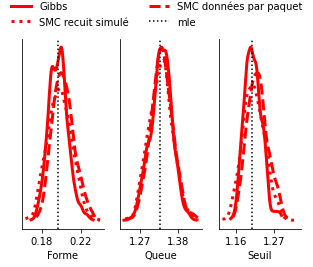

In [22]:
np.random.seed(123)
fig, axs = plt.subplots(1, 3, figsize=(5, 3.5))
loss_model = "lnorm-par"
for k in range(3):
    positions = np.linspace(min(trace_gibbs_lnorm_par[parms_names[k]]), max(trace_gibbs_lnorm_par[parms_names[k]]), 1000)
    kernel = st.gaussian_kde(trace_gibbs_lnorm_par[parms_names[k]])
    axs[k].plot(positions, kernel(positions), lw=3, label = "Gibbs", color = "red")
    positions = np.linspace(min(traces_like[loss_model][parms_names[k]].values), 
                            max(traces_like[loss_model][parms_names[k]].values), 1000)
    kernel = st.gaussian_kde(traces_like[loss_model][parms_names[k]].values)
    axs[k].plot(positions, kernel(positions), lw=3, label = "SMC recuit simulé", 
                color = "red", linestyle = "dotted")
    positions = np.linspace(min(traces_data[loss_model][parms_names[k]].values), 
                            max(traces_data[loss_model][parms_names[k]].values), 1000)
    kernel = st.gaussian_kde(traces_data[loss_model][parms_names[k]].values)
    axs[k].plot(positions, kernel(positions), lw=3, label = "SMC données par paquet", 
                color = "red", linestyle = "dashed")

    axs[k].axvline(fit_lnorm_par[parms_names[k]].values, color = "black", linestyle = "dotted", label = "mle")
    axs[k].set_yticks([])
    axs[k].set_xlabel(x_labs[k])
    axs[k].set_xticks(np.round(
        traces_like[loss_model][parms_names[k]].quantile([0.05, 0.95]).values, 2))

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol = 2, borderaxespad=-0.2, loc='upper center', 
           frameon=False)
sns.despine()
print(fit_gam_par[parms_names[0]].values)
plt.savefig("../Figures/smc_posterior_danish_lnorm_par.pdf")

In [27]:
print(res_df_data.to_latex(index = False, columns = ["loss_model","log_marg","model_evidence",  "DIC", "WAIC"]))
res_df_data

\begin{tabular}{lrrrr}
\toprule
loss\_model &     log\_marg &  model\_evidence &         DIC &        WAIC \\
\midrule
 lnorm-par & -3885.040162 &    5.725112e-13 & 7726.257157 & 7744.072965 \\
   wei-par & -3856.851418 &    1.000000e+00 & 7674.313085 & 7689.683870 \\
   gam-par & -3877.090150 &    1.623418e-09 & 7711.846158 & 7729.252382 \\
\bottomrule
\end{tabular}



,loss_model,log_marg,DIC,WAIC,shape,tail,thres,model_evidence
0,lnorm-par,-3885.040162,7726.257157,7744.072965,0.201882,1.334007,1.220950,5.725112e-13
0,wei-par,-3856.851418,7674.313085,7689.683870,13.825170,1.262611,1.006294,1.000000e+00
0,gam-par,-3877.090150,7711.846158,7729.252382,33.602540,1.318446,1.170365,1.623418e-09


In [28]:
print(res_df_like.to_latex(index = False, columns = ["loss_model","log_marg","model_evidence",  "DIC", "WAIC"]))
res_df_like

\begin{tabular}{lrrrr}
\toprule
loss\_model &     log\_marg &  model\_evidence &         DIC &        WAIC \\
\midrule
 lnorm-par & -3882.643584 &    3.463073e-11 & 7725.542624 & 7745.727944 \\
   wei-par & -3858.557304 &    1.000000e+00 & 7674.303196 & 7689.579069 \\
   gam-par & -3878.110908 &    3.220903e-09 & 7711.154332 & 7730.754869 \\
\bottomrule
\end{tabular}



,loss_model,log_marg,DIC,WAIC,shape,tail,thres,model_evidence
0,lnorm-par,-3882.643584,7725.542624,7745.727944,0.196602,1.327861,1.208039,3.463073e-11
0,wei-par,-3858.557304,7674.303196,7689.579069,14.001460,1.260769,1.004157,1.000000e+00
0,gam-par,-3878.110908,7711.154332,7730.754869,34.355530,1.316779,1.165583,3.220903e-09
